In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

# Function to extract GLCM features from an image
def extract_features(image):
    # Calculate GLCM
    glcm = graycomatrix(image, distances=[2], angles=[2 * np.pi/4], levels=256,
                        symmetric=True, normed=True)

    # Extract GLCM features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]

    # Extract edge features
    edges = cv2.Canny(image, threshold1=30, threshold2=70)
    edge_mean = np.mean(edges)
    edge_std = np.std(edges)
    edge_max = np.max(edges)
    edge_min = np.min(edges)
    edge_skewness = np.mean((edges - np.mean(edges)) ** 3) / np.mean((edges - np.mean(edges)) ** 2) ** (3 / 2)
    edge_kurtosis = np.mean((edges - np.mean(edges)) ** 4) / np.mean((edges - np.mean(edges)) ** 2) ** 2
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])

    all_features = [contrast, energy, homogeneity, correlation, dissimilarity, edge_mean, edge_std, edge_max, edge_min, edge_skewness, edge_kurtosis, edge_density]

    return all_features

In [ ]:
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to load images from a folder and extract features
def load_images_and_extract_features(folder_path, size=(150, 100)):
    X = []  # Feature vectors
    y = []  # Labels

    # Loop through each subfolder in the main folder
    for subdir in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subfolder_path):  # Check if it's a directory
            # Loop through each file in the subfolder
            for filename in os.listdir(subfolder_path):
                # Check if the file is an image
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    # Load the image
                    image_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    image_resized = cv2.resize(image, size, interpolation=cv2.INTER_LANCZOS4)

                    # Extract features from GLCM
                    features = extract_features(image_resized)
                    X.append(features)

                    # Append the label (name of the subfolder)
                    y.append(subdir)

    return np.array(X), np.array(y)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

folder_path = '\rps-cv-images'
X, y = load_images_and_extract_features(folder_path, size=(150, 100))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

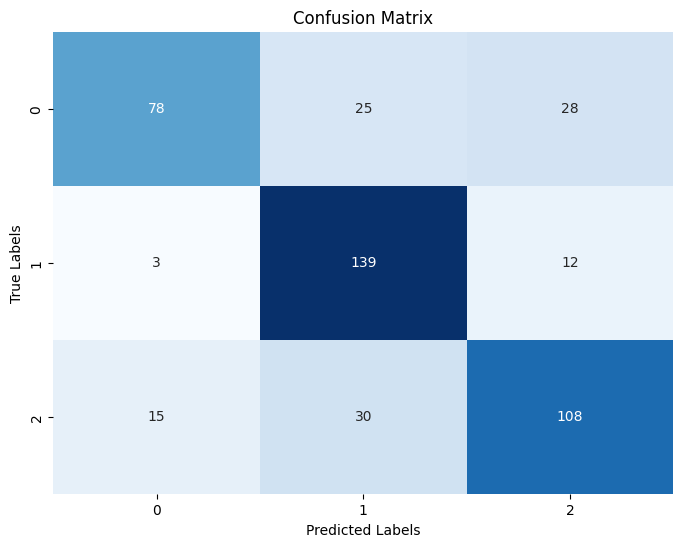

              precision    recall  f1-score   support

       paper       0.81      0.60      0.69       131
        rock       0.72      0.90      0.80       154
    scissors       0.73      0.71      0.72       153

    accuracy                           0.74       438
   macro avg       0.75      0.73      0.73       438
weighted avg       0.75      0.74      0.74       438



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Instantiate the SVM classifier
svm_classifier = SVC()

svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(report)

In [ ]:
import scipy.stats as stats

# Example data (replace this with your actual data)
data = np.array(X)

# Perform Shapiro-Wilk test for each column
shapiro_results = []
for i in range(data.shape[1]):
    statistic, p_value = stats.shapiro(data[:, i])
    shapiro_results.append((statistic, p_value))

# Check if each column is normally distributed
for i, result in enumerate(shapiro_results):
    statistic, p_value = result
    print(f"Column {i+1}: Shapiro-Wilk Test - Statistic: {statistic}, p-value: {p_value}")
    if p_value > 0.05:
        print("   The data may be normally distributed.")
    else:
        print("   The data may not be normally distributed.")


Column 1: Shapiro-Wilk Test - Statistic: 0.9467105865478516, p-value: 1.915109106994696e-27
   The data may not be normally distributed.
Column 2: Shapiro-Wilk Test - Statistic: 0.9913403987884521, p-value: 3.804826176345699e-10
   The data may not be normally distributed.
Column 3: Shapiro-Wilk Test - Statistic: 0.994554340839386, p-value: 3.363723237725935e-07
   The data may not be normally distributed.
Column 4: Shapiro-Wilk Test - Statistic: 0.9444854259490967, p-value: 6.116170428083198e-28
   The data may not be normally distributed.
Column 5: Shapiro-Wilk Test - Statistic: 0.9942688345909119, p-value: 1.7029036314397672e-07
   The data may not be normally distributed.
Column 6: Shapiro-Wilk Test - Statistic: 0.9861403107643127, p-value: 9.67906717231834e-14
   The data may not be normally distributed.
Column 7: Shapiro-Wilk Test - Statistic: 0.9562813639640808, p-value: 4.1186593029341057e-25
   The data may not be normally distributed.
Column 8: Shapiro-Wilk Test - Statistic: 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# Define the parameter grid for grid search
param_grid = {
    'kernel': ['linear'],
    'C': [0.1, 1],
    'class_weight': [None, 'balanced'],
    'probability': [True, False]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=stratified_kfold, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Use the best model for prediction
best_model_linear = grid_search.best_estimator_
y_pred = best_model_linear.predict(X_test)

# Evaluate the model
accuracy = best_model_linear.score(X_test, y_test)
print("Accuracy:", accuracy)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END C=0.1, class_weight=None, kernel=linear, probability=True; total time=   4.4s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=True; total time=   5.9s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=True; total time=   5.5s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=True; total time=   4.5s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=True; total time=   5.1s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=False; total time=   0.9s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=False; total time=   0.8s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=False; total time=   0.9s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=False; total time=   0.8s
[CV] END C=0.1, class_weight=None, kernel=linear, probability=False; total time=   0.5s
[CV] END C=0.1, class_weight=balanced, kernel=linear, probability

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# Define the parameter grid for grid search
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1],
    'gamma': [1, 10, 100, 1000],
    'class_weight': [None, 'balanced'],
    'probability': [True, False]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=stratified_kfold, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Use the best model for prediction
best_model_rbf = grid_search.best_estimator_
y_pred = best_model_rbf.predict(X_test)

# Evaluate the model
accuracy = best_model_rbf.score(X_test, y_test)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=True; total time=   1.5s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=True; total time=   1.3s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=True; total time=   0.8s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=True; total time=   0.8s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=True; total time=   0.8s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=False; total time=   0.2s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=False; total time=   0.2s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=False; total time=   0.2s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=False; total time=   0.2s
[CV] END C=0.1, class_weight=None, gamma=1, kernel=rbf, probability=False; total time=   0.2s
[CV

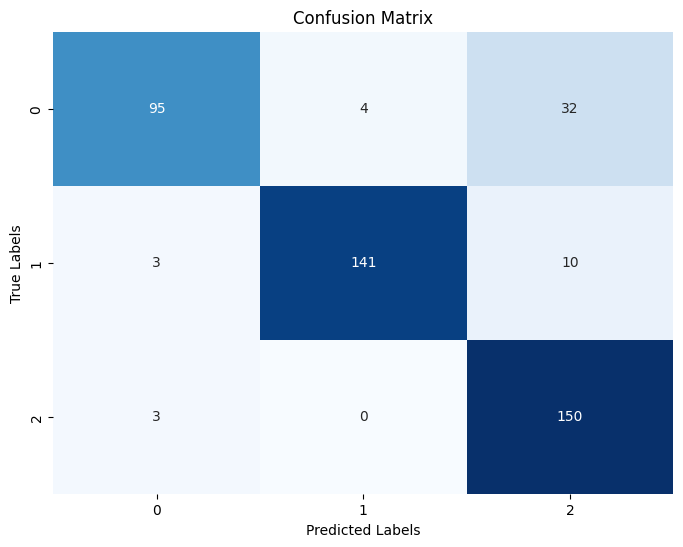

              precision    recall  f1-score   support

       paper       0.94      0.73      0.82       131
        rock       0.97      0.92      0.94       154
    scissors       0.78      0.98      0.87       153

    accuracy                           0.88       438
   macro avg       0.90      0.87      0.88       438
weighted avg       0.90      0.88      0.88       438



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

new_model = SVC(C=10, class_weight=None, kernel='linear', probability=True)

new_model.fit(X_train, y_train)

y_pred = new_model.predict(X_test)

report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(report)

In [ ]:
import pickle

# Serialize the model
with open('new_model.pkl', 'wb') as f:
    pickle.dump(new_model, f)